In [10]:
from transformers import pipeline, AutoTokenizer, CamembertForSequenceClassification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from labels import LABELS

/Users/maximekuil/Documents/Simplon/fine-tune-classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Définition du modèle

In [3]:
# https://camembert-model.fr/posts/tutorial/#:~:text=Il%20faut%20enfin%20s'assurer,cette%20limite%20de%20512%20tokens.
model_name = "mtheo/camembert-base-xnli"
candidate_labels=list(map(lambda x: x.lower(), LABELS))


In [5]:
import pandas as pd

data = "../dataset.csv"

df = pd.read_csv(data)
df.head(3)

,Unnamed: 0,url,title,description,cat1,cat2,cat3
0,0,https://www.tourisme-cambresis.fr/1-les-templi...,"Aventure-jeu : ""Les Templiers du coffre d'or""",Le jeu aventure « Les templiers du coffre d’or...,Jeu,Famille,Détente
1,1,https://www.tourisme-cambresis.fr/exposition-t...,"Exposition ""le tank dans tous ses états""","L'apparition des tanks, arme de guerre incarna...",Exposition,Culture,NaN
2,1,https://www.tourisme-cambresis.fr/femme-premie...,"Exposition ""La femme au premier millénaire""",L’exposition vous invite à une plongée au cœur...,Exposition,Culture,NaN


# clean

In [7]:
df_new = df.copy()
for label in LABELS:
  df_new.insert(df_new.shape[1], label, pd.Series(0, dtype=int, index=range(df_new.shape[0])))

for row in df_new.iterrows():
  for cat in ['cat1', 'cat2', 'cat3']:
    for cat_col in LABELS:
      if row[1].loc[cat] == cat_col:
        df_new.at[row[0], cat_col] = 1
        break

df_new.drop(columns=['cat1', 'cat2', 'cat3', 'url'], inplace=True)
df_new = df_new.iloc[:, 1:]
df_new.head(2)

,title,description,Balade,Spectacle,Culture,Détente,Fête,Gastronomie,Famille,Sport,...,Concert,Exposition,Jeu,Visite,Histoire,Art,Brocante,Action,Santé,Conférence
0,"Aventure-jeu : ""Les Templiers du coffre d'or""",Le jeu aventure « Les templiers du coffre d’or...,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,"Exposition ""le tank dans tous ses états""","L'apparition des tanks, arme de guerre incarna...",0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [11]:
print(df_new.description.isnull().sum())

df_new.dropna(subset=['description'], inplace=True)

0


# split

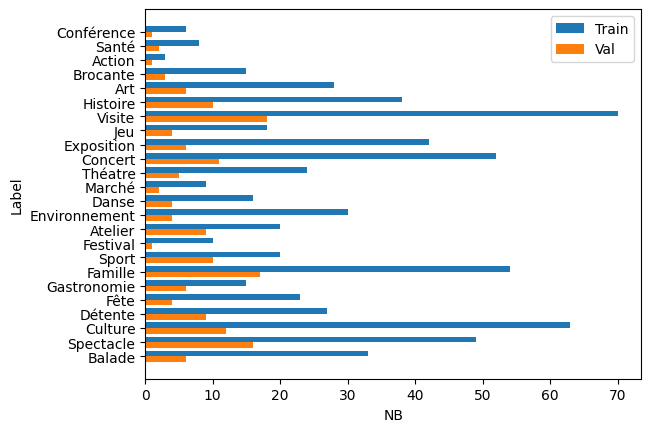

In [12]:
train_df, val_df = train_test_split(df_new, test_size=.2, shuffle=True, random_state=42)
#train_df[LABELS].sum().sort_values().plot(kind='barh')
#val_df[LABELS].sum().sort_values().plot(kind='barh')

plt.barh(np.arange(len(LABELS)) + .2, train_df[LABELS].sum(), 0.4, label = 'Train')
plt.barh(np.arange(len(LABELS)) - .2, val_df[LABELS].sum(), 0.4, label = 'Val')

plt.yticks(np.arange(len(LABELS)), LABELS)
plt.xlabel("NB")
plt.ylabel("Label")
plt.legend()
plt.show()


In [13]:
X = df_new.drop(columns=LABELS)
y = np.array(df_new.drop(columns=['description', 'title']))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state = 42,
                                                   #stratify = y,
                                                   shuffle=True)

# ds = Dataset.from_pandas(df_new, split="train")

# sample = ds.shuffle(seed=333).select(range(3))
# for description, title in zip(sample["title"], sample["description"]):
#     print(f">> Title: {title}\n")
#     print(f">> description: {description}")

In [14]:
class EventDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer = None,
    max_token_len: int = 128
  ):
    self.df = data
    self.tokenizer = tokenizer if tokenizer is not None else AutoTokenizer.from_pretrained("camembert-base")
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index: int):
    data_row = self.df.iloc[index]

    description_text = data_row.description
    labels = data_row[LABELS]

    self.encoding = self.tokenizer.encode_plus(
      description_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      description_text=description_text.strip().replace('\n', ' '),
      input_ids=self.encoding["input_ids"].flatten(),
      attention_mask=self.encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

  def tokenized_str(self, input_id):
    return self.tokenizer.convert_ids_to_tokens(input_id.squeeze())

Pour savoir le nombre de token dans les descriptions

/Users/maximekuil/Documents/Simplon/fine-tune-classification/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


True


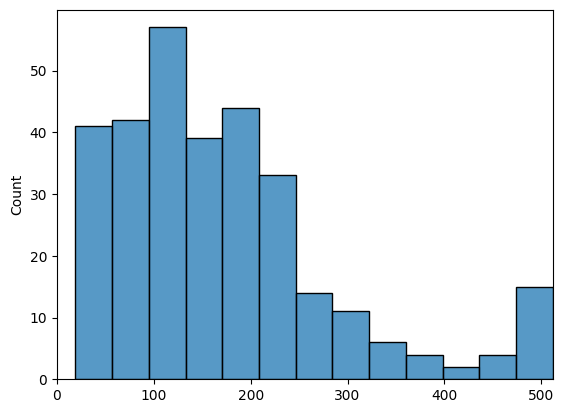

In [15]:
tokenizer = AutoTokenizer.from_pretrained("camembert-base")
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["description"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0, 512])

print((train_df["description"].apply(lambda x: len(x)) > 512).any())

In [16]:
tokenizer = None

train_dataset = EventDataset(df_new, tokenizer=tokenizer, max_token_len=512)

sample_item = train_dataset[1]
display(sample_item.keys())

print(sample_item['description_text'])

print(train_dataset.tokenized_str(sample_item['input_ids']))

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_21502/983273034.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels=torch.FloatTensor(labels)


dict_keys(['description_text', 'input_ids', 'attention_mask', 'labels'])

L'apparition des tanks, arme de guerre incarnant une nouvelle dimension de la guerre moderne, va donner lieu au développement d'un équipement spécifique et à la production de nombreux objets à son image (affiches, photos, cartes postales, objets de la vie quotidienne...)  Fruit d'un long travail de recherche et de collecte, cette exposition présente une série inédite d'objets ayant trait à l'usage et l'image du tank.     Le centre d'interprétation de la Bataille de Cambrai est ouvert durant toutes les vacances d'été de 14h à 17h30.
['<s>', '▁L', "'", 'apparition', '▁des', '▁tank', 's', ',', '▁arme', '▁de', '▁guerre', '▁in', 'car', 'nant', '▁une', '▁nouvelle', '▁dimension', '▁de', '▁la', '▁guerre', '▁moderne', ',', '▁va', '▁donner', '▁lieu', '▁au', '▁développement', '▁d', "'", 'un', '▁équipement', '▁spécifique', '▁et', '▁à', '▁la', '▁production', '▁de', '▁nombreux', '▁objets', '▁à', '▁son', '▁image', '▁(', 'affiche', 's', ',', '▁photos', ',', '▁cartes', '▁postales', ',', '▁objets', '▁de

# test brut

In [ ]:
str_test1 = df.loc[0]["description"]
str_test2 = df.loc[146]["description"]

str_test = str_test2

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = CamembertForSequenceClassification.from_pretrained(model_name)

classifier = pipeline(task="zero-shot-classification", model=model, tokenizer=tokenizer)
res = classifier(str_test, candidate_labels=candidate_labels)

# t = tokenizer(str_test)
# print(tokenizer.tokenize(str_test))
display(res)

{'sequence': 'Uramado AR est un parcours en réalité augmentée de l’artiste illustratrice Julie Stephen Chheng.\n\nCette exposition ludique et poétique nous invite à suivre des Tanukis, yokai (esprit) de la forêt emblématique de la culture folklorique japonaise.\n\nSous son aspect de petit animal malicieux la peau du ventre bien tendue, se cache une créature bien singulière !\n\nCette exposition pour petits et grands invite à questionner nos différences en créant une narration où le réel se mêle à l’imaginaire et se décline à l’infini.\n\nDes Tanukis se sont installés dans 8 médiathèques. Allez-vous réussir à les trouver et répondre à leurs questions ?\n\nPour participer à cette chasse aux trésors, il suffit de se rendre dans l’une des médiathèques participantes et de télécharger l’application gratuite URAMADO AR, le réveil des Tanukis (sur iOS et Android).\n\nAu fur et à mesure de la découverte, les esprits s’animent, s’étonnent et vous questionnent. En fonction de vos réponses, vous d

# fine tune

In [ ]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(model_name)

ModuleNotFoundError: No module named 'setfit'